# 🍅 **Tomato Leaf Disease** #

## 🎯 Project Description  ###
Tomatoes are one of the most extensively grown vegetables in any country, and their diseases can significantly affect yield and quality. Accurate and early detection of tomato diseases is crucial for reducing losses and improving crop management.

In this project, I will be appllying the power of Deep Learning to detect and classify the various stages of blight in tomato leaves. , making automation of disease detection more efficient and accessible.

## 📃 The Dataset #
The dataset consists of 3 different folders, each containing images of tomato leaves with the respective syndroms:
- Healthy
- Early blight
- Late blight

## 📚 The Notebook Structure ###
- ⚙️ Notebook Preparation - Import libraries, initialize constants and download dataset.
- 🔎 Data Exploration - Visualize data and confirm the distribution of different classes.
- 🪓 Data Splitting - Split data into Train, Validation and Testing sets.
- 🧹 Data Preprocessing - Load and preprocess images to ensure compatibility with neural networks.
- 🛠️ Model Building - Build a CNN model using TensorFlow.
- 📈 Model Training - Train model on the dataset, and use a separate validation set to monitor its performance.
- 📊 Model Evaluation - Evaluate the model's performance on a separate test set.
- 🔝 Model Improvement - Try different strategies to improve the model's performance.
- 🖼️ Result Visualization $ Interpretation - Visualize the results.

## 1️. ⚙️ Notebook Preparation

### Import dependencies.

In [28]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# General libraries
import os
import datetime
import random
import shutil
import glob
import pandas as pd
import numpy as np
from kaggle.api.kaggle_api_extended import KaggleApi

# Data Analysis libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image

# Machine Learning libraries
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

### Initilaize paths and constants.

In [5]:
# Dataset
KAGGLE_DATASET = 'charuchaudhry/plantvillage-tomato-leaf-dataset'

# Paths
MODEL_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'models'))
MAIN_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
RAW_PATH = os.path.join(MAIN_PATH, 'raw_data', '')
TEST_PATH = os.path.join(MAIN_PATH, 'test_split', '')
TRAIN_PATH = os.path.join(MAIN_PATH, 'train_split', '')
PLANTVILLAGE = os.path.join(MAIN_PATH, 'plantvillage', '')

# Constants
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180


### Download the dataset from Kaggle and create a folder structure for our data.###
This requires having set a Kaggle API key in our local root directory. You can download your own API key by navigating to your Kaggle Profile > Account > API > Create New Token. The downloaded .json file will then have to be placed in  "~/.kaggle/kaggle.json" (if the folder .kaggle does not exist, create it).

In [6]:
# Create Data folder structure
if not os.path.exists(MAIN_PATH):
    os.makedirs(MAIN_PATH, exist_ok=True)

    for path in [RAW_PATH, TRAIN_PATH, TEST_PATH]:
        if not os.path.exists(path):
            os.makedirs(path, exist_ok=True)

    # Instantiate Kaggle API (requires local API Key)
    print('Authenticating...', end=' ')
    api = KaggleApi()
    api.authenticate()

    # Download the dataset to the local folder and unzip
    print('Downloading...', end=' ')
    api.dataset_download_files(KAGGLE_DATASET, path=MAIN_PATH, unzip=True)

    print('Unzipping...', end=' ')
    for folder in os.listdir(PLANTVILLAGE):
        if folder == 'Tomato___healthy' or folder == 'Tomato___Early_blight' or folder == 'Tomato___Late_blight':
            source_path = os.path.join(PLANTVILLAGE, folder)

            # Rename folder
            new_folder = folder.replace('Tomato___', '').lower()
            new_path = os.path.join(PLANTVILLAGE, new_folder)
            os.rename(source_path, new_path)

            # Move the subfolder to the destination folder
            shutil.move(new_path, RAW_PATH)

    shutil.rmtree(PLANTVILLAGE)

    # Define split ratio of 80% train and 20% test
    print('Splitting...')
    split_ratio = 0.8

    for class_folder in os.listdir(RAW_PATH):
        class_path = os.path.join(RAW_PATH, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            random.shuffle(files)

            # Separating raw data into train and test splits
            split_index = int(len(files) * split_ratio)
            train_files = files[:split_index]
            test_files = files[split_index:]

            # Creating folders for each class of the train split
            dest_train_folder = os.path.join(TRAIN_PATH, class_folder)
            if not os.path.exists(dest_train_folder):
                os.makedirs(dest_train_folder, exist_ok=True)
            else:
                continue

            # Creating folders for each class of the test split
            dest_test_folder = os.path.join(TEST_PATH, class_folder)
            if not os.path.exists(dest_test_folder):
                os.makedirs(dest_test_folder, exist_ok=True)
            else:
                continue

            # Move train split files to train folder
            for file in train_files:
                source_file = os.path.join(class_path, file)
                dest_file = os.path.join(dest_train_folder, file)
                shutil.copy(source_file, dest_file)

            # Move test split files to test folder
            for file in test_files:
                source_file = os.path.join(class_path, file)
                dest_file = os.path.join(dest_test_folder, file)
                shutil.copy(source_file, dest_file)
    print('✅ Dataset successfully downloaded!')
else:
    print('✅ Dataset already downloaded!')

✅ Dataset already downloaded!


## 2. 🔎 Data Exploration ##

### First, we are going to count the number of images that is available per class. 

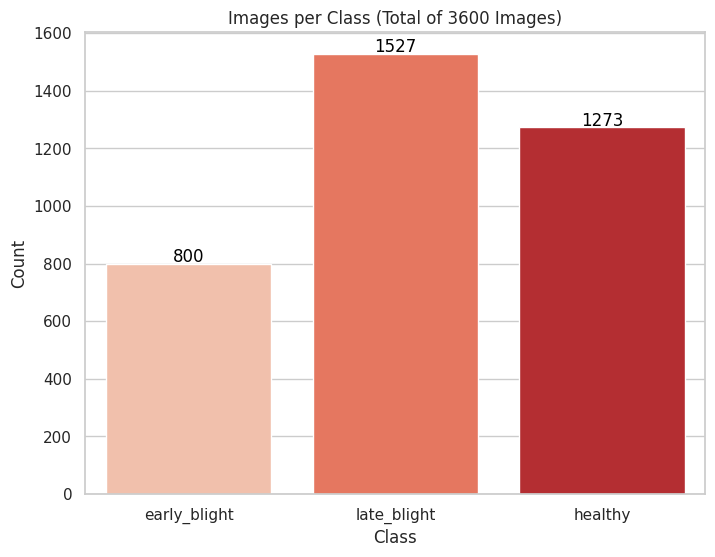

In [7]:
classes = ['early_blight', 'late_blight', 'healthy']
class_counts = {}

# Count images per class
for class_name in classes:
    class_path = os.path.join(RAW_PATH, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

# Count total images
total_count = sum(class_counts.values())

# Create plotable dict
data = {
    'Class': list(class_counts.keys()),
    'Count': list(class_counts.values())
}

# Visualize counts
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

ax = sns.barplot(x='Class', y='Count', data=data, palette="Reds")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

ax.set_title(f'Images per Class (Total of {total_count} Images)')
ax.set_xlabel('Class')
ax.set_ylabel('Count')

plt.show()

### Let's have a look at some of the images so we know what we are dealing with. 

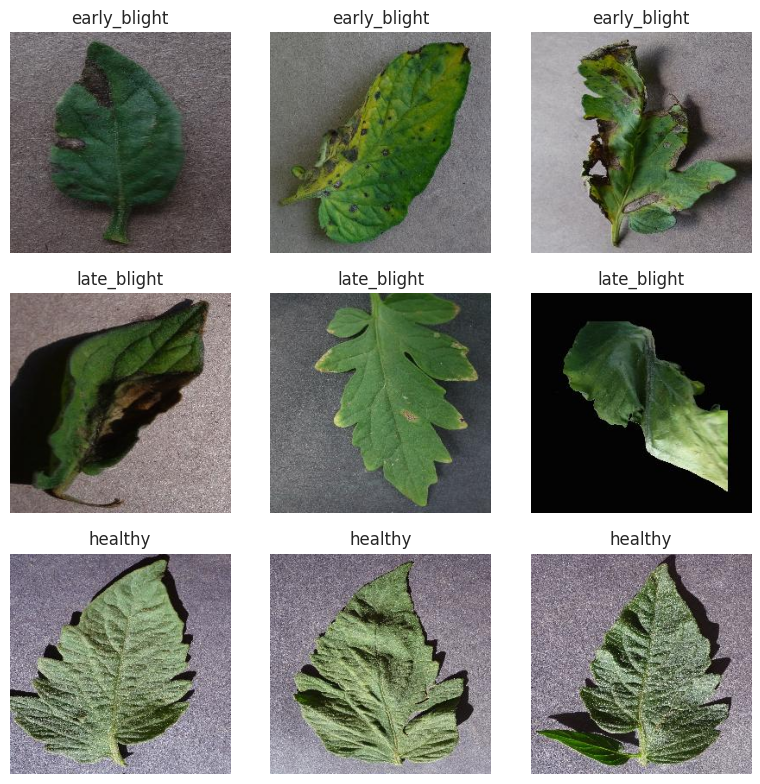

In [8]:
plt.figure(figsize=(8, 8))

for idx, folder in enumerate(classes, start=1):
    folder_path = os.path.join(RAW_PATH, folder)
    image_files = os.listdir(folder_path)[:3]  # Get the first 3 image files

    for i, image_file in enumerate(image_files, start=1):
        image_path = os.path.join(folder_path, image_file)
        img = Image.open(image_path)

        plt.subplot(3, 3, (idx - 1) * 3 + i)
        plt.imshow(img)
        plt.title(f'{folder}')
        plt.axis('off')

plt.tight_layout()
plt.show()

## 3. 🪓 Data Splitting

### We are going to split the data into the following 3 subsets:
- Training
- Validation
- Testing

Please note that we already took care of separating training (80%) and testing (20%) data when we dowloaded the kaggle dataset and created the folder structure. However, we still need to load both subsets into our Notebook, as well as splitting off the validation from our training set.

In [9]:
# Load and further split train_split into train and validation
train_data, val_data = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.2,
    subset="both",
    seed=21,
    image_size= (IMG_HEIGHT, IMG_WIDTH),
    batch_size= BATCH_SIZE
)

class_names = train_data.class_names

Found 2879 files belonging to 3 classes.
Using 2304 files for training.
Using 575 files for validation.


2024-01-03 15:34:48.002353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-01-03 15:34:48.003062: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-03 15:34:48.003111: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (JarisLaptop): /proc/driver/nvidia/version does not exist
2024-01-03 15:34:48.007536: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Load testing data
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)


Found 721 files belonging to 3 classes.


### Let's check if the numbers are still adding up to the previous total of 3600 images!

In [11]:
def images_per_split(data) -> dict:
    classes = {
        'early_blight': 0,
        'healthy': 0,
        'late_blight': 0
    }

    for i in data:
        for j in i[1]:
            if j == 0:
                classes['early_blight'] += 1
            elif j == 1:
                classes['healthy'] += 1
            else:
                classes['late_blight'] += 1

    return classes


In [12]:
data_splits = {
    'train': images_per_split(train_data),
    'val': images_per_split(val_data),
    'test': images_per_split(test_data)
}

data_splits_df = pd.DataFrame(data_splits)
data_splits_df['total'] = data_splits_df.sum(axis=1)
data_splits_df.loc['total'] = data_splits_df.sum()
data_splits_df

,train,val,test,total
early_blight,502,138,160,800
healthy,823,195,255,1273
late_blight,979,242,306,1527
total,2304,575,721,3600


## 4. 🧹 Data Preprocessing

### To ensure all our images are compatible with Neural Networks, we will perform some data cleaning and preprocessing.
- Applying several data pipeline optimizations using TensorFlow's tf.data API to improve performance during training and evaluation later on.
- The pixel values for all 3 RGB (red, green, blue) channels are between 0 and 255. We can normalize these values to be between 0 and 1 by using a rescaling layer to increase model performance and stability, as seen in the model building step below. However, we are doing this step here as well to gain access to the input shape of the images.

In [13]:
autotune = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=autotune)
val_data = val_data.cache().prefetch(buffer_size=autotune)
test_data = test_data.cache().prefetch(buffer_size=autotune)

In [14]:
normalization_layer = layers.Rescaling(1./255)

norm_train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(norm_train_data))

print(f'Image: {image_batch[0].numpy()}', '\n')
print(f'Lables: {labels_batch}')

Image: [[[0.69524914 0.66387653 0.6521118 ]
  [0.70897317 0.6776006  0.6658359 ]
  [0.7131639  0.68179137 0.67002666]
  ...
  [0.47654885 0.4216469  0.4098822 ]
  [0.57099324 0.5160913  0.5043266 ]
  [0.52020985 0.4653079  0.4535432 ]]

 [[0.6911068  0.65973425 0.64796954]
  [0.6829935  0.6516209  0.6398562 ]
  [0.6885185  0.657146   0.6453813 ]
  ...
  [0.65054554 0.5956436  0.5838789 ]
  [0.53027046 0.47536853 0.46360382]
  [0.47068146 0.4157795  0.4040148 ]]

 [[0.7060543  0.6746817  0.662917  ]
  [0.68047935 0.6491068  0.63734204]
  [0.67995644 0.6485839  0.6368192 ]
  ...
  [0.56027704 0.5053751  0.49361035]
  [0.5003923  0.44549033 0.43372563]
  [0.5648344  0.5099324  0.49816775]]

 ...

 [[0.7112246  0.6680873  0.66024417]
  [0.71167773 0.6685405  0.66069734]
  [0.71638864 0.6732514  0.66540825]
  ...
  [0.57829964 0.52731925 0.50378984]
  [0.5729997  0.5220193  0.49848986]
  [0.6269965  0.5760161  0.5524867 ]]

 [[0.7180422  0.67490494 0.6670618 ]
  [0.7418389  0.6987016  0.690

In [15]:
print('Shape of an image batch:', image_batch.shape)
print('Batch Size:  ', image_batch.shape[0])
print('Image Height:', image_batch.shape[1])
print('Image Width: ', image_batch.shape[2])
print('Channels:    ', image_batch.shape[3], '\n')

# Required input shape
input_shape = image_batch.shape[1:]
print('Input Shape: ', input_shape)


Shape of an image batch: (32, 180, 180, 3)
Batch Size:   32
Image Height: 180
Image Width:  180
Channels:     3 

Input Shape:  (180, 180, 3)


## 5. 🛠️ Model Building

### We are initializing a sequential model and add several layers to it:
- **Rescaling layer:**       Normalizes pixel values to [0, 1] range for preprocessing.
- **Convolutional layers:**  Applies 32 or 64 convolutional filters of size 3x3 for feature extraction.
- **Max Pooling layers:**    Reduces spatial dimensions by taking maximum value in each 2x2 region.
- **Flatten Layer:**         Flattens the output into a vector for dense layers.
- **Dense Layer (ReLU):**    Fully connected layer with ReLU activation for learning high-level features.
- **Dense Layer (Softmax):** Final output layer using softmax activation for multi-class classification.


In [57]:
def initialize_model():
    model = models.Sequential()

    model.add(layers.Rescaling(1./255, input_shape = image_batch.shape[1:]))

    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))

    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(2, 2))

    model.add(layers.Flatten())

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])

    # Early stopping condition for the model training later
    early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

    return model, early_stopping


In [58]:
model, early_stopping =initialize_model()

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 45, 45, 64)       

## 6. 📈 Model Training

### Training the first model with the created CNN and saving it for later use.

In [19]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 50,
    verbose = 1,
    callbacks = [early_stopping]
)

Epoch 1/50


72/72 [==============================] - 45s 600ms/step - loss: 0.8659 - accuracy: 0.5794 - val_loss: 0.4344 - val_accuracy: 0.8383
Epoch 2/50
72/72 [==============================] - 42s 588ms/step - loss: 0.4268 - accuracy: 0.8234 - val_loss: 0.3887 - val_accuracy: 0.8487
Epoch 3/50
72/72 [==============================] - 42s 579ms/step - loss: 0.2608 - accuracy: 0.8967 - val_loss: 0.2920 - val_accuracy: 0.8696
Epoch 4/50
72/72 [==============================] - 41s 573ms/step - loss: 0.2122 - accuracy: 0.9128 - val_loss: 0.2967 - val_accuracy: 0.8661
Epoch 5/50
72/72 [==============================] - 41s 575ms/step - loss: 0.2413 - accuracy: 0.9041 - val_loss: 0.2816 - val_accuracy: 0.8696
Epoch 6/50
72/72 [==============================] - 41s 572ms/step - loss: 0.1889 - accuracy: 0.9232 - val_loss: 0.3278 - val_accuracy: 0.8696
Epoch 7/50
72/72 [==============================] - 38s 532ms/step - loss: 0.1666 - accuracy: 0.9336 - val_loss: 0.2142 - val_accuracy: 0.9113
Epoch 8/50

In [39]:
def save_model(model):
    # Savind a model
    now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    model_name = f'model_{now}'

    model.save(os.path.join(MODEL_PATH, model_name))
    print("✅ Model saved locally")

    return None

def load_model():
    # Loading a locally saved model
    local_model_paths = glob.glob(f"{MODEL_PATH}/*")

    # Return latest model
    model_path_on_disk = sorted(local_model_paths)[-1]
    model = keras.models.load_model(model_path_on_disk)
    print(f"✅ Model loaded from local disk {model_path_on_disk}")

    return model

In [40]:
save_model(model)

INFO:tensorflow:Assets written to: /home/jarisfenner/code/Kaaykun/TomatoLeafDisease/models/model_2024-01-03_16-06-40/assets


INFO:tensorflow:Assets written to: /home/jarisfenner/code/Kaaykun/TomatoLeafDisease/models/model_2024-01-03_16-06-40/assets


✅ Model saved locally


## 7. 📊 Model Evaluation

In [41]:
print(history.history.keys())
history.history['val_accuracy']

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


[0.8382608890533447,
 0.8486956357955933,
 0.8695651888847351,
 0.8660869598388672,
 0.8695651888847351,
 0.8695651888847351,
 0.9113043546676636,
 0.8226087093353271,
 0.852173924446106,
 0.895652174949646,
 0.9026086926460266,
 0.9182608723640442,
 0.8782608509063721,
 0.9060869812965393,
 0.9269565343856812,
 0.8817391395568848,
 0.8991304636001587]

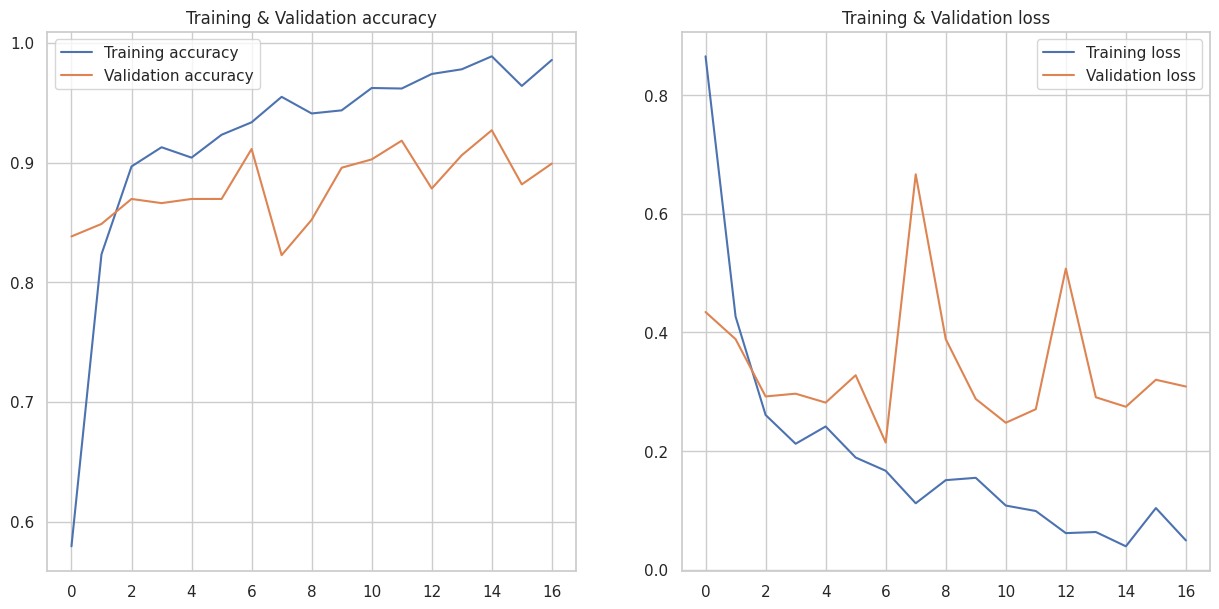

In [65]:
def plot_history(history):
    history_length = len(history.history['accuracy'])

    plt.figure(figsize = (15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(range(history_length), history.history['accuracy'], label = 'Training accuracy')
    plt.plot(range(history_length), history.history['val_accuracy'], label = 'Validation accuracy')
    plt.legend()
    plt.title('Training & Validation accuracy')



    plt.subplot(1, 2, 2)
    plt.plot(range(history_length), history.history['loss'], label = 'Training loss')
    plt.plot(range(history_length), history.history['val_loss'], label = 'Validation loss')
    plt.legend()
    plt.title('Training & Validation loss')
    plt.show()

    return None

plot_history(history)

In [43]:
test_accuracy = model.evaluate(test_data)
print(f'Accuracy on test data: {test_accuracy[1]}')

23/23 [==============================] - 4s 180ms/step - loss: 0.1849 - accuracy: 0.9459
Accuracy on test data: 0.9459084868431091


### Model test accuracy is already at **~94.5%**. However, I would like to check and see if the accuracy can be further improved by applying data augmendation.

## 8. 🔝 Model Improvement

### We will be applying a few data augmentations such as:
- Random Rotation
- Random Translation
- Random Zoom
- Random Flip

### I am hoping that increasing the diversity of the data helps imrpoving the model performance.

In [46]:
aug_data = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split = 0.2
)

In [49]:
aug_train_data = aug_data.flow_from_directory(
    directory = TRAIN_PATH,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    color_mode = 'rgb',
    class_mode = 'sparse',
    batch_size = BATCH_SIZE,
    shuffle = True,
    subset = 'training'
)


Found 2304 images belonging to 3 classes.


In [55]:
aug_val_data = aug_data.flow_from_directory(
    directory = TRAIN_PATH,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    color_mode = 'rgb',
    class_mode = 'sparse',
    batch_size = BATCH_SIZE,
    shuffle = True,
    subset = 'validation'
)


Found 575 images belonging to 3 classes.


### Let's check out a few sample pictures from the augmented data.

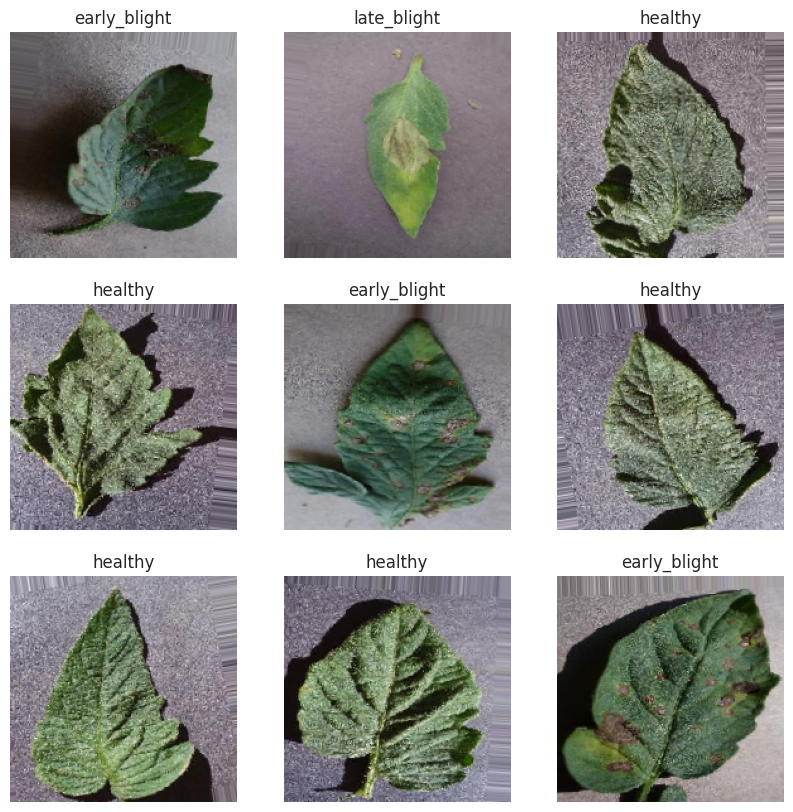

In [60]:
images, labels = next(aug_train_data)
labels = labels.astype('int32')

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


### Next, we initialize a new model and train it on the augmented data.

In [61]:
aug_model, aug_early_stoping = initialize_model()

In [62]:
aug_history = aug_model.fit(
    aug_train_data,
    validation_data = aug_val_data,
    epochs = 50,
    verbose = 1,
    callbacks = [aug_early_stoping]
)

Epoch 1/50
72/72 [==============================] - 48s 661ms/step - loss: 0.8855 - accuracy: 0.5846 - val_loss: 0.6200 - val_accuracy: 0.7130
Epoch 2/50
72/72 [==============================] - 50s 693ms/step - loss: 0.4740 - accuracy: 0.7938 - val_loss: 0.3155 - val_accuracy: 0.8713
Epoch 3/50
72/72 [==============================] - 49s 674ms/step - loss: 0.4574 - accuracy: 0.8016 - val_loss: 0.3263 - val_accuracy: 0.8643
Epoch 4/50
72/72 [==============================] - 47s 651ms/step - loss: 0.3339 - accuracy: 0.8555 - val_loss: 0.3190 - val_accuracy: 0.8539
Epoch 5/50
72/72 [==============================] - 47s 657ms/step - loss: 0.2482 - accuracy: 0.8963 - val_loss: 0.2096 - val_accuracy: 0.9078
Epoch 6/50
72/72 [==============================] - 51s 712ms/step - loss: 0.2441 - accuracy: 0.8971 - val_loss: 0.2055 - val_accuracy: 0.9374
Epoch 7/50
72/72 [==============================] - 42s 586ms/step - loss: 0.2240 - accuracy: 0.9054 - val_loss: 0.2071 - val_accuracy: 0.9043

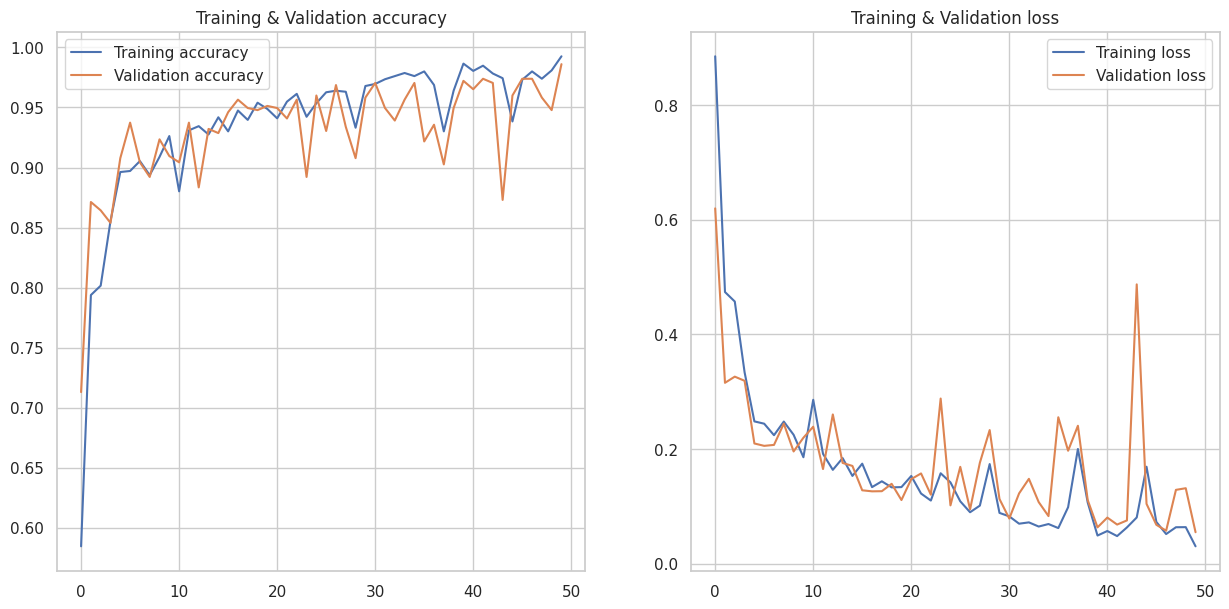

In [66]:
plot_history(aug_history)

In [68]:
aug_test_accuracy = aug_model.evaluate(test_data)
print(f'Accuracy on test data: {aug_test_accuracy[1]}')


 1/23 [>.............................] - ETA: 2s - loss: 0.0117 - accuracy: 1.0000

23/23 [==============================] - 4s 154ms/step - loss: 0.2408 - accuracy: 0.9875
Accuracy on test data: 0.9875173568725586


In [71]:
final_model = model if test_accuracy[1] > aug_test_accuracy[1] else aug_model
save_model(final_model)

INFO:tensorflow:Assets written to: /home/jarisfenner/code/Kaaykun/TomatoLeafDisease/models/model_2024-01-03_17-35-19/assets


INFO:tensorflow:Assets written to: /home/jarisfenner/code/Kaaykun/TomatoLeafDisease/models/model_2024-01-03_17-35-19/assets


✅ Model saved locally


## 9. 🎯 Result interpretation

1/1 [==============================] - 0s 145ms/step


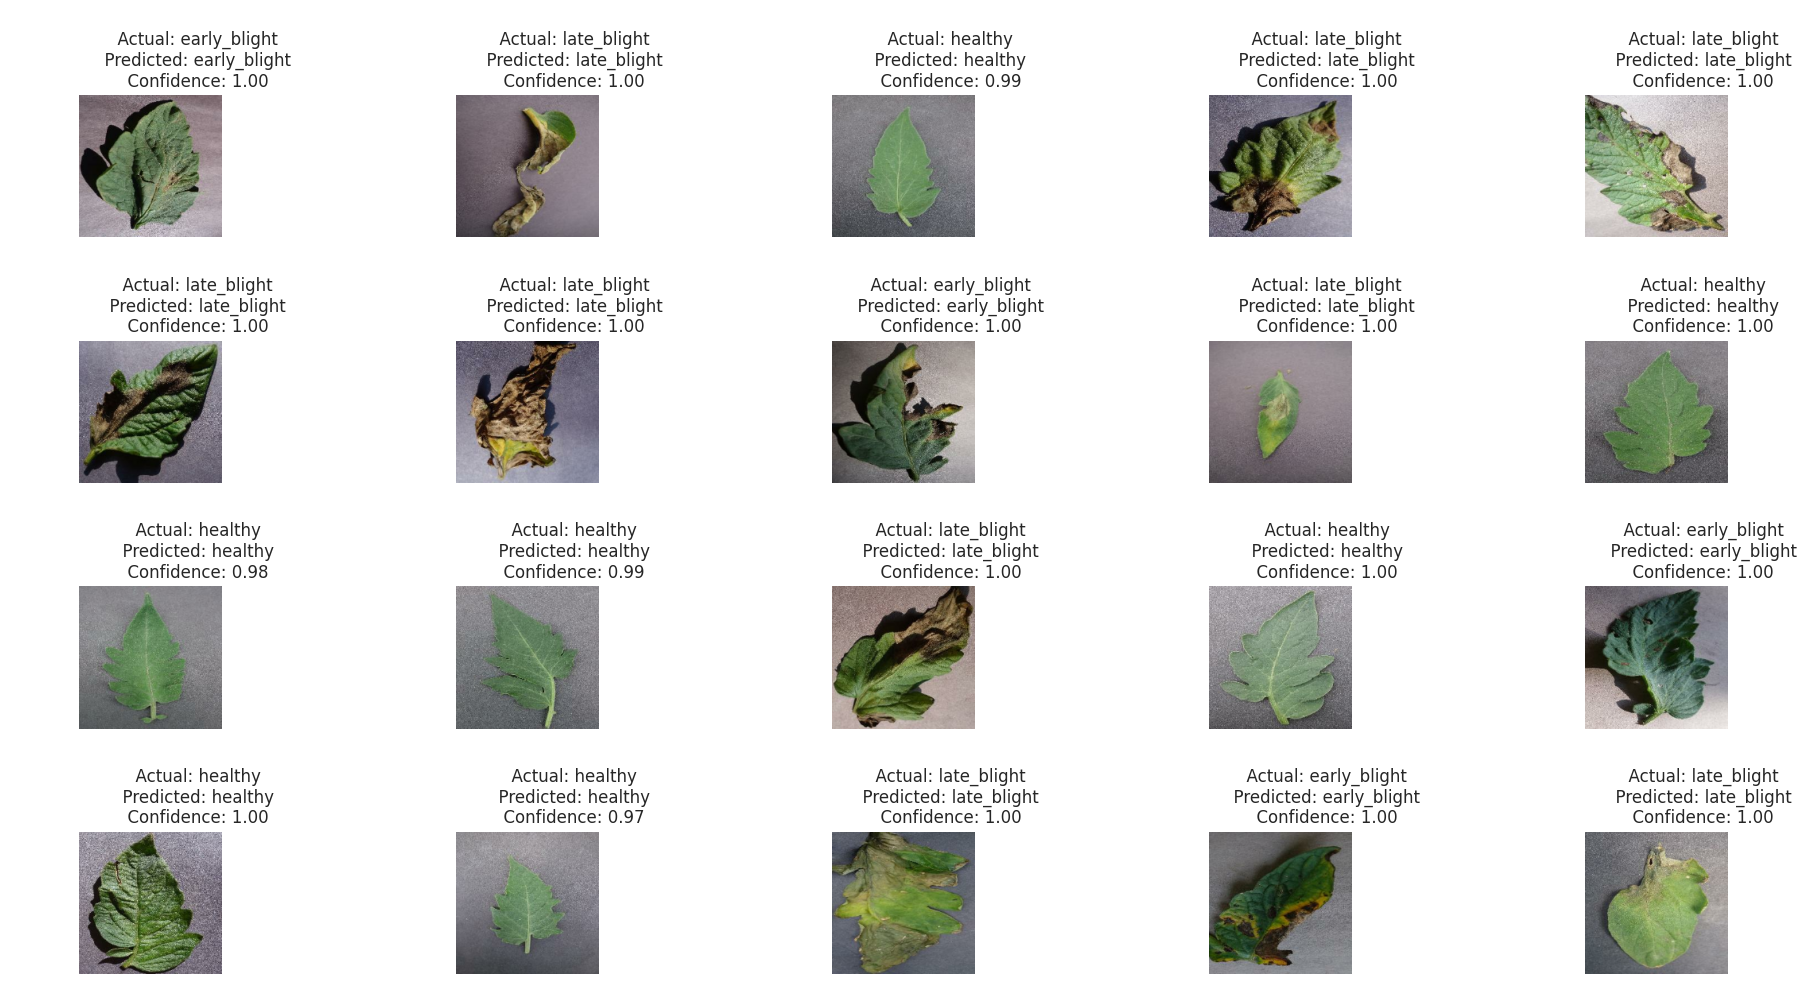

In [75]:
for images, labels in test_data.take(1):

    test_images = images.numpy()
    test_labels = labels.numpy()


    predictions = final_model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)
    predicted_confidences = np.max(predictions, axis=1)


    test_labels_str = [class_names[i] for i in test_labels]
    predicted_labels_str = [class_names[i] for i in predicted_labels]

    plt.figure(figsize=(20, 10))
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(test_images[i].astype("uint8"))
        plt.title(f"""
                  Actual: {test_labels_str[i]}
                  Predicted: {predicted_labels_str[i]}
                  Confidence: {predicted_confidences[i]:.2f}""")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

### The use of data augmentation in my image classification task has shown improvement. The accuracy went from 94% to almost 99%. However, the initial model already high a very high accuracy. Here are a few reasons why the improvement might not be as significant as expected: ###

- Already High Accuracy: The original model without data augmentation already achieved an accuracy of 94%. As the model's performance increases, it becomes progressively harder to achieve large improvements.

- Sufficient Training Data: I belive that my original dataset was already large and diverse enough, the benefits of data augmentation are less noticeable.

- Overfitting: While data augmentation can help reduce overfitting, it doesn't necessaricly prevent it completely. Other factors include the model's complexity, the presence of noise in the training data, and so on.

### With that being said, our model seems to be detecting the 3 classes Healthy, Early Blight and Late Blight with very high confidence and accuracy. I am therefore quiet certain that it has not been overfitted and generalizes unseen data quiet well!